# CycleGAN

## Main Reference
1. [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)
2. [CycleGAN | Github/junyanz | Torch implementation for learning an image-to-image translation without input-output pairs](https://github.com/junyanz/CycleGAN)

![image](https://miro.medium.com/max/2692/0*S5gn5i6UhfyoRr9S.png)

## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Weight Setting
Step 9. Configure Optimizer
Step 10. Learning Rate Scheduler Setting
Step 11. Image Transformation Setting
Step 12. DataLoader Setting
Step 13. Define function to get sample images
Step 14. Training
```
---

### Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial Setting

In [2]:
# number of cpu (in kaggle server)
!cat /proc/cpuinfo | grep processor

processor	: 0
processor	: 1


In [3]:
n_cpu = 2 # number of cpu threads to use during batch generation

In [4]:
# data (path)
dataset_name = 'gan-getting-started'
root = '../input/'+dataset_name

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay


### Step 3. Define Generator

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

> TEST CODE : nn.Upsample

In [6]:
tensor = torch.from_numpy(np.random.randn(2,2))

In [7]:
tensor

tensor([[-0.0810,  1.5680],
        [-0.3294, -0.3216]], dtype=torch.float64)

In [8]:
tensor = tensor.view(1,1,2,2)
tensor # nn.Upsample get only 3/4/5D tensor

tensor([[[[-0.0810,  1.5680],
          [-0.3294, -0.3216]]]], dtype=torch.float64)

In [9]:
test_m = nn.Upsample(scale_factor=2)
test_m(tensor)

tensor([[[[-0.0810, -0.0810,  1.5680,  1.5680],
          [-0.0810, -0.0810,  1.5680,  1.5680],
          [-0.3294, -0.3294, -0.3216, -0.3216],
          [-0.3294, -0.3294, -0.3216, -0.3216]]]], dtype=torch.float64)

> Read More
- [torch.nn.ReflectionPad2d(padding)](https://pytorch.org/docs/stable/generated/torch.nn.ReflectionPad2d.html)
- [torch.nn.InstanceNorm2d(num_features, ...)](https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm2d.html)
    - Example : Compare 4dim-Normalization methods,https://wdprogrammer.tistory.com/67

![image](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fa23e53c6-47a1-4ae6-96b0-f4836b5d82a8%2FUntitled.png?table=block&id=2e5405fd-24c7-49e1-aa2e-69a80d8b4bf4&width=2800&cache=v2)
- [torch.nn.Upsample(size=None, scale_factor=None, mode='nearest', align_corners=None)](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html)

### Step 4. Define Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

> TEST CODE : nn.ZeroPad2d

In [11]:
tensor = torch.from_numpy(np.random.randn(2,2))
tensor

tensor([[1.0792, 0.2029],
        [0.1849, 1.1966]], dtype=torch.float64)

In [12]:
test_m = nn.ZeroPad2d((1,0,0,0)) # Padding_left
test_m(tensor)

tensor([[0.0000, 1.0792, 0.2029],
        [0.0000, 0.1849, 1.1966]], dtype=torch.float64)

In [13]:
test_m = nn.ZeroPad2d((0,1,0,0)) # Padding_right
test_m(tensor)

tensor([[1.0792, 0.2029, 0.0000],
        [0.1849, 1.1966, 0.0000]], dtype=torch.float64)

In [14]:
test_m = nn.ZeroPad2d((0,0,1,0)) # Padding_top
test_m(tensor)

tensor([[0.0000, 0.0000],
        [1.0792, 0.2029],
        [0.1849, 1.1966]], dtype=torch.float64)

In [15]:
test_m = nn.ZeroPad2d((0,0,0,1)) # Padding_bottom
test_m(tensor)

tensor([[1.0792, 0.2029],
        [0.1849, 1.1966],
        [0.0000, 0.0000]], dtype=torch.float64)

In [16]:
test_m = nn.ZeroPad2d((1,0,1,0)) # Padding_left and Padding_top
test_m(tensor)

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 1.0792, 0.2029],
        [0.0000, 0.1849, 1.1966]], dtype=torch.float64)

### Step 5. Define Loss

In [17]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

### Step 6. Initialize Generator and Discriminator

In [18]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

### Step 7. GPU Setting

In [19]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

### Step 8. Weight Setting

In [20]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [21]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

> TEST CODE : `__class__.__name__`


In [22]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [23]:
G_AB.apply(temp_weights_init_normal);

ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPa

`torch.nn.init.normal_(tensor, mean=0.0, std=1.0)`
- Fills the input Tensor with values drawn from the normal distribution N(mean, std^2)

In [24]:
temp_w = torch.ones(2,5)
temp_w

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [25]:
nn.init.normal_(temp_w)

tensor([[-0.9643, -0.1283, -2.4493, -1.1440, -0.5088],
        [-0.5158,  0.4273, -2.0654,  0.6438,  0.7455]])

`torch.nn.init.constant_(tensor, val)`
- Fills the input Tensor with value `val`


In [26]:
temp_w2 = torch.empty(2,5)
temp_w2

tensor([[-7.5644e-15,  3.0771e-41,  7.0720e+23,  3.0771e-41,  1.1210e-43],
        [ 0.0000e+00,  1.1210e-43,  0.0000e+00,  7.0726e+23,  3.0771e-41]])

In [27]:
nn.init.constant_(temp_w2, 1)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

> Read More
- [Torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)

### Step 9. Configure Optimizers

In [28]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

### Step 10. Learning Rate Scheduler Setting

In [29]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [30]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

### Step 11. Image Transformation Setting

In [31]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

### Step 12. DataLoader Setting

In [32]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [33]:
import os
import glob

In [34]:
print(root+'/monet_jpg')

../input/gan-getting-started/monet_jpg


In [35]:
len(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*'))

300

In [36]:
len(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*'))

7038

In [37]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[250:301])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

In [38]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

### Step 13. Define function to get sample images

In [39]:
import matplotlib.pyplot as plt

In [40]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [41]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

> TEST CODE : show image data

In [42]:
temp_imgs = next(iter(val_dataloader))

In [43]:
G_AB.eval() # test mode 
G_BA.eval() # test mode
print(temp_imgs['A'].shape)
print(temp_imgs['B'].shape)


torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [44]:
temp_real_A = temp_imgs['A'].type(Tensor) # A : monet
temp_fake_B = G_AB(temp_real_A).detach()
temp_real_B = temp_imgs['B'].type(Tensor) # B : photo
temp_fake_A = G_BA(temp_real_B).detach()

In [45]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [46]:
temp_real_A = make_grid(temp_real_A, nrow=5, normalize=True)
temp_real_B = make_grid(temp_real_B, nrow=5, normalize=True)
temp_fake_A = make_grid(temp_fake_A, nrow=5, normalize=True)
temp_fake_B = make_grid(temp_fake_B, nrow=5, normalize=True)

In [47]:
type(temp_real_A)

torch.Tensor

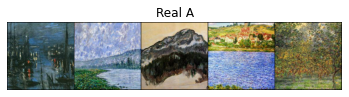

In [48]:
plt.imshow(temp_real_A.cpu().permute(1,2,0))
plt.title('Real A')
plt.axis('off');

In [49]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])


In [50]:
temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
print(temp_image_grid.shape)

torch.Size([3, 1040, 1292])


In [51]:
temp_image_grid.cpu().permute(1,2,0).shape

torch.Size([1040, 1292, 3])

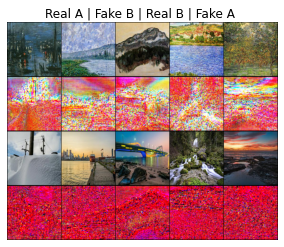

In [52]:
plt.imshow(temp_image_grid.cpu().permute(1,2,0))
plt.title('Real A | Fake B | Real B | Fake A ')
plt.axis('off');

### Step 14. Training

In [53]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

  0%|          | 0/250 [00:00<?, ?it/s]

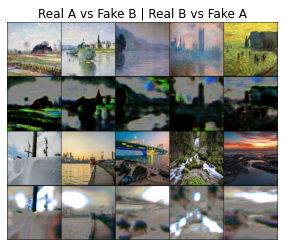

[Epoch 1/5] [Batch 50/250] [D loss : 0.344885] [G loss : 4.778842 - (adv : 0.647677, cycle : 0.284838, identity : 0.256557)]


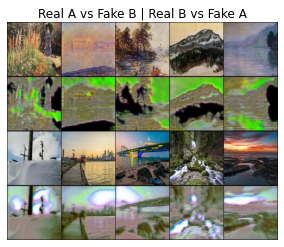

[Epoch 1/5] [Batch 100/250] [D loss : 0.218024] [G loss : 9.277887 - (adv : 0.428426, cycle : 0.597219, identity : 0.575454)]


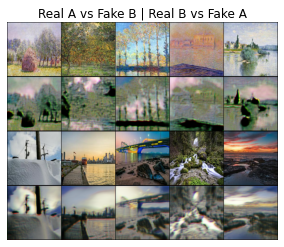

[Epoch 1/5] [Batch 150/250] [D loss : 0.313071] [G loss : 4.612592 - (adv : 0.361550, cycle : 0.294688, identity : 0.260831)]


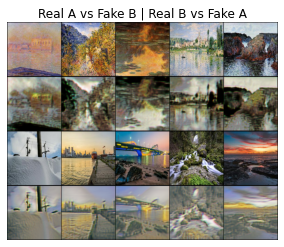

[Epoch 1/5] [Batch 200/250] [D loss : 0.210498] [G loss : 3.085846 - (adv : 0.453077, cycle : 0.177715, identity : 0.171124)]


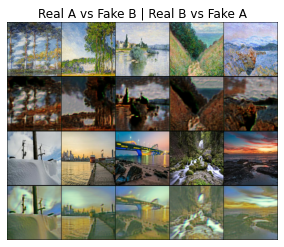

[Epoch 1/5] [Batch 250/250] [D loss : 0.362501] [G loss : 3.566026 - (adv : 0.561126, cycle : 0.205021, identity : 0.190937)]


  0%|          | 0/250 [00:00<?, ?it/s]

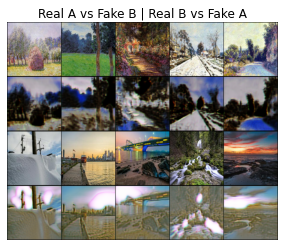

[Epoch 2/5] [Batch 50/250] [D loss : 0.182507] [G loss : 4.634626 - (adv : 0.563709, cycle : 0.283442, identity : 0.247300)]


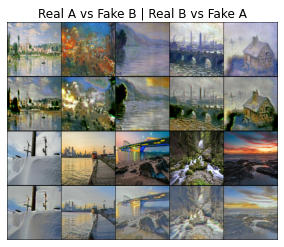

[Epoch 2/5] [Batch 100/250] [D loss : 0.159998] [G loss : 7.622628 - (adv : 0.826691, cycle : 0.480351, identity : 0.398486)]


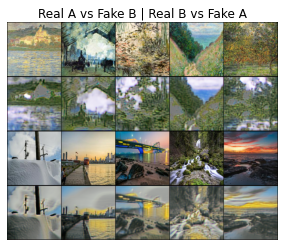

[Epoch 2/5] [Batch 150/250] [D loss : 0.270175] [G loss : 3.619542 - (adv : 0.344776, cycle : 0.219269, identity : 0.216415)]


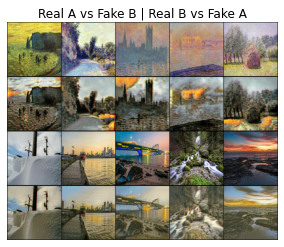

[Epoch 2/5] [Batch 200/250] [D loss : 0.251157] [G loss : 3.637742 - (adv : 0.392379, cycle : 0.224947, identity : 0.199179)]


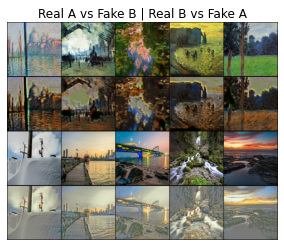

[Epoch 2/5] [Batch 250/250] [D loss : 0.293970] [G loss : 4.174608 - (adv : 0.275004, cycle : 0.271880, identity : 0.236161)]


  0%|          | 0/250 [00:00<?, ?it/s]

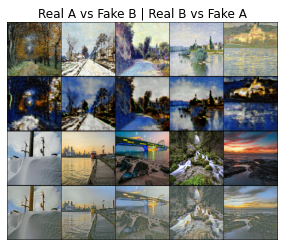

[Epoch 3/5] [Batch 50/250] [D loss : 0.221044] [G loss : 3.900741 - (adv : 0.900216, cycle : 0.208472, identity : 0.183161)]


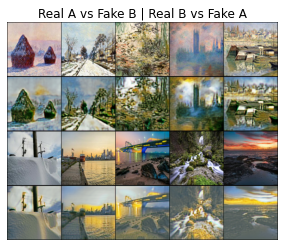

[Epoch 3/5] [Batch 100/250] [D loss : 0.202131] [G loss : 6.127533 - (adv : 0.912917, cycle : 0.353577, identity : 0.335769)]


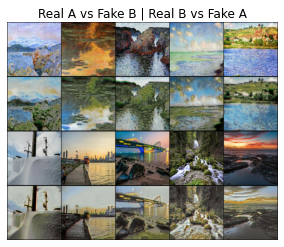

[Epoch 3/5] [Batch 150/250] [D loss : 0.147596] [G loss : 5.859245 - (adv : 0.432396, cycle : 0.374847, identity : 0.335677)]


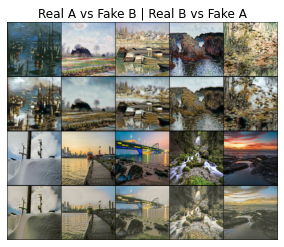

[Epoch 3/5] [Batch 200/250] [D loss : 0.234136] [G loss : 3.771558 - (adv : 0.411707, cycle : 0.237159, identity : 0.197652)]


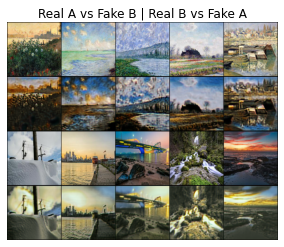

[Epoch 3/5] [Batch 250/250] [D loss : 0.175339] [G loss : 3.749094 - (adv : 0.637411, cycle : 0.206418, identity : 0.209500)]


  0%|          | 0/250 [00:00<?, ?it/s]

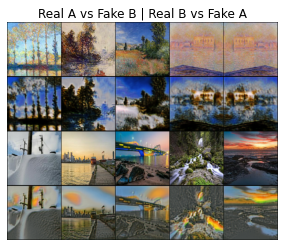

[Epoch 4/5] [Batch 50/250] [D loss : 0.114859] [G loss : 4.742976 - (adv : 0.578172, cycle : 0.297043, identity : 0.238876)]


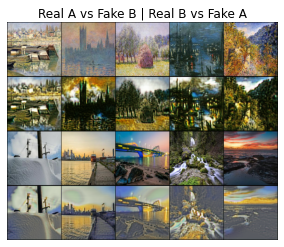

[Epoch 4/5] [Batch 100/250] [D loss : 0.127350] [G loss : 5.377274 - (adv : 0.582983, cycle : 0.320125, identity : 0.318608)]


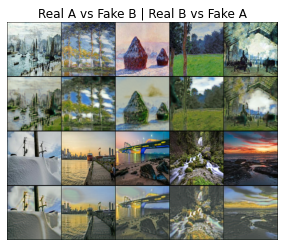

[Epoch 4/5] [Batch 150/250] [D loss : 0.209711] [G loss : 3.804630 - (adv : 0.359382, cycle : 0.235458, identity : 0.218133)]


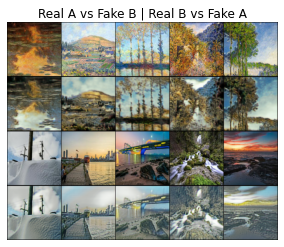

[Epoch 4/5] [Batch 200/250] [D loss : 0.155420] [G loss : 3.012181 - (adv : 0.470593, cycle : 0.172400, identity : 0.163518)]


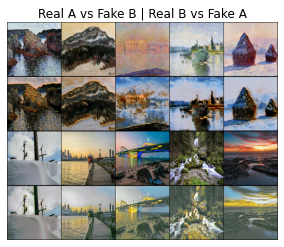

[Epoch 4/5] [Batch 250/250] [D loss : 0.234161] [G loss : 2.745006 - (adv : 0.374009, cycle : 0.163664, identity : 0.146872)]


  0%|          | 0/250 [00:00<?, ?it/s]

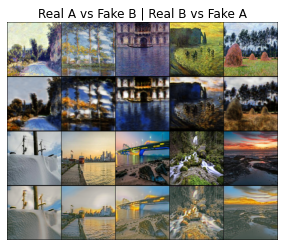

[Epoch 5/5] [Batch 50/250] [D loss : 0.155265] [G loss : 3.886686 - (adv : 0.742559, cycle : 0.214967, identity : 0.198892)]


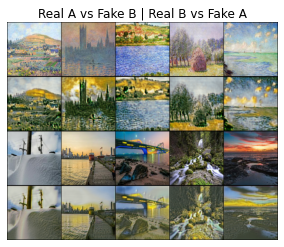

[Epoch 5/5] [Batch 100/250] [D loss : 0.125907] [G loss : 6.502981 - (adv : 0.606158, cycle : 0.421372, identity : 0.336620)]


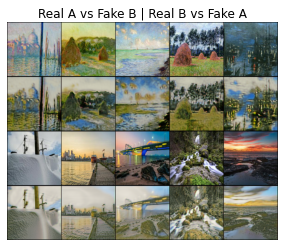

[Epoch 5/5] [Batch 150/250] [D loss : 0.210080] [G loss : 3.510880 - (adv : 0.396191, cycle : 0.210996, identity : 0.200945)]


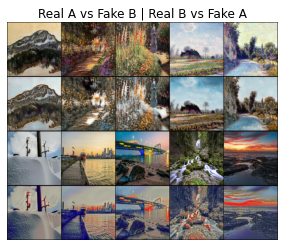

[Epoch 5/5] [Batch 200/250] [D loss : 0.173403] [G loss : 3.252918 - (adv : 0.444193, cycle : 0.189311, identity : 0.183124)]


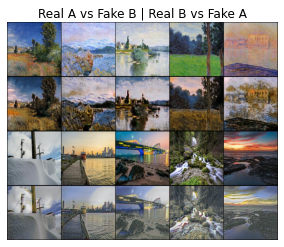

[Epoch 5/5] [Batch 250/250] [D loss : 0.106656] [G loss : 3.886137 - (adv : 0.723649, cycle : 0.222951, identity : 0.186596)]


In [54]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
# ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
# -----------------
# Show Progress
# -----------------
        if (i+1) % 50 == 0:
            sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))



> TEST CODE : check iteration and image shape

In [55]:
for i, batch in enumerate(dataloader):
    print('iter : {}  A.size : {}'.format(i,batch['A'].size()))
    print('iter : {}  B.size : {}'.format(i,batch['B'].size()))
    if i == 10:
        break

iter : 0  A.size : torch.Size([1, 3, 256, 256])
iter : 0  B.size : torch.Size([1, 3, 256, 256])
iter : 1  A.size : torch.Size([1, 3, 256, 256])
iter : 1  B.size : torch.Size([1, 3, 256, 256])
iter : 2  A.size : torch.Size([1, 3, 256, 256])
iter : 2  B.size : torch.Size([1, 3, 256, 256])
iter : 3  A.size : torch.Size([1, 3, 256, 256])
iter : 3  B.size : torch.Size([1, 3, 256, 256])
iter : 4  A.size : torch.Size([1, 3, 256, 256])
iter : 4  B.size : torch.Size([1, 3, 256, 256])
iter : 5  A.size : torch.Size([1, 3, 256, 256])
iter : 5  B.size : torch.Size([1, 3, 256, 256])
iter : 6  A.size : torch.Size([1, 3, 256, 256])
iter : 6  B.size : torch.Size([1, 3, 256, 256])
iter : 7  A.size : torch.Size([1, 3, 256, 256])
iter : 7  B.size : torch.Size([1, 3, 256, 256])
iter : 8  A.size : torch.Size([1, 3, 256, 256])
iter : 8  B.size : torch.Size([1, 3, 256, 256])
iter : 9  A.size : torch.Size([1, 3, 256, 256])
iter : 9  B.size : torch.Size([1, 3, 256, 256])
iter : 10  A.size : torch.Size([1, 3, 25

> TEST CODE : Adversarial Ground Truths

In [56]:
temp_A = batch['A'].type(Tensor)

In [57]:
temp_A.shape

torch.Size([1, 3, 256, 256])

In [58]:
temp_img = temp_A.squeeze()
temp_img = temp_img.cpu().permute(1,2,0).numpy()

In [59]:
temp_img.shape

(256, 256, 3)

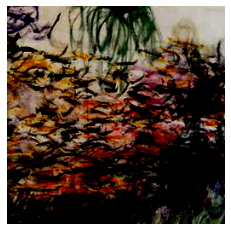

In [60]:
plt.imshow(temp_img)
plt.axis('off');

In [61]:
D_A.output_shape

(1, 16, 16)

In [62]:
temp_A.size()

torch.Size([1, 3, 256, 256])

In [63]:
temp_A.size(0) # batch_size

1

In [64]:
Tensor(np.ones((temp_A.size(0), *D_A.output_shape)))

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1

In [65]:
Tensor(np.ones((temp_A.size(0), *D_A.output_shape))).shape

torch.Size([1, 1, 16, 16])

> Read More
- [The Effect of the Identity Mapping Loss on Monet's painting](https://www.researchgate.net/figure/The-effect-of-the-identity-mapping-loss-on-Monets-painting-photos-From-left-to-right_fig3_322060135)